# Final Project

This project models vehicular traffic in two lanes, based on the traffic equation and systems of hyperbolic equations studied in class.

In [1]:
%precision 3
%matplotlib inline

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.optimize import fsolve

# support.py includes code taken directly from the lecture notebooks, such as 
# slope limiters and the ode_rkexplicit function.
%run support.py

## Setup: One-Dimensional Traffic Equation

In the textbook, LeVeque discusses the one-dimensional traffic equation, shown below, which models the movement of vehicular traffic as a wave. 

$$ \rho_t + (\rho u)_x = 0 $$

Here, $\rho(x, t)$ is the density of cars ($0 \leq \rho \leq \rho_M$) and $u(\rho)$ is velocity ($0 \leq u \leq u_M$). Holmes uses the same form, noting some example choices for the velocity function:

* $u(\rho) = a$, constant velocity (advection equation)
* $u(\rho) = u_M \left(1 - \frac{\rho}{\rho_M}\right)$, linear velocity
* $u(\rho) = a \rho \log\left(\frac{\rho_M}{\rho} \right)$, derived from Newell's model

$\rho_M$ is the maximum density, and $u_M$ is the maximum velocity. The linear choice is convenient and straightforward, modelling how traffic tends to slow down as vehicle density increases. This model was used in lecture, where we used $\rho_M = 1$ and $u_M$ = 1. This results in the differential equation

\begin{align*}
&\rho_t + (\rho(1-\rho))_x = 0 &\rho(x, t) \in [0,1]
\end{align*}

With this equation, $\rho=0$ represents an empty road, resulting in free-flowing traffic, while $\rho=1$ represents bumper-to-bumper traffic.

There are no source terms in the equations above; this gives us the behavior of a featureless segment of a single travel lane. Modelling entrance and exit ramps would contribute to a source term; in a system of equations for a multilane road, relationships between lanes would result in a source term, as well.



## Traffic in Two Lanes

Munjal and Pipes discuss traffic across multiple lanes travelling in the same direction, using the following model.

\begin{align*}
(\rho_1)_t + (f_1)_x = Q_1\\
(\rho_2)_t + (f_2)_x = Q_2
\end{align*}

$\rho_i$ is the density of traffic in lane $i$. $f_i(\rho)$ is the flux in lane $i$, equivalent to $\rho_iu_i$ from the last section. $Q_i$ is the net traffic flow per unit distance entering lane $i$ from outside it, which could be affected by an adjacent lane or ramp.

In the case of two lanes with no ramps connecting other roads, using the system above, we have $Q_2 = -Q_1$. Vehicles may only leave their current lane for the other, and no vehicles enter or leave the system. The authors model this movement as

\begin{align*}
Q_1 &= a (K_2 - K_1)\\
K_i &= \rho_i - \rho_{i,eq}
\end{align*}

$K_i$ is referred to as the density perturbation in lane $i$, describing the rifference between the current traffic density $\rho_i$ and the equilibrium density $\rho_{i,eq}$. $a$ is a constant that affects the rate of lane switching. The idea behind $Q_i$ is that vehicles will switch from a crowded lane to a clearer one until both are carrying the same density of traffic. The rate at which vehicles change is linearly proportional to how far off the current densities are from the equilibrium densities.

$\rho_{i,eq}$ is based on integrating over an indeal speed distribution for lane $i$; for this project, I will assume that the ideal distribution of traffic is to have both lanes carrying equal volumes, so $\rho_{1,eq} = \rho_{2,eq} = \rho_{eq}$. $Q_1$ then simplifies:

\begin{align*}
Q_1 &= a \left((\rho_2 - \rho_{eq}) - (\rho_1 - \rho_{eq})\right)\\
&= a (\rho_2 - \rho_1)
\end{align*}

This says that the exchange of vehicles between two lanes is directly proportional to the difference in traffic densities between the lanes. The 'eagerness' of drivers to change lanes is controlled by $a$.

Written in matrix form, similar to that used in the lecture notebook for the isentropic gas equations and Euler equations, this system looks like

$$U_t + f(U)_x = Q$$

with these values

\begin{align}
U &= \begin{bmatrix} \rho_1 \\ \rho_2 \end{bmatrix} & 
f(U) &= \begin{bmatrix} \rho_1(1-\rho_1) \\ \rho_2(1-\rho_2) \end{bmatrix} &
Q(U) & = \begin{bmatrix} a(\rho_2-\rho_1) \\ a(\rho_1-\rho_2) \end{bmatrix}
\end{align}

The flux Jacobian for this system is

$$ f'(U) = \begin{bmatrix} 1 - 2\rho_1 & 0 \\ 0 & 1 - 2\rho_2 \end{bmatrix} $$

The eigenvalues of this matrix are $\lambda_1 = 1 - 2\rho_1$ and $\lambda_2 = 1 - 2\rho_2$.

With this, we can set up a Riemann solver for the problem.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11

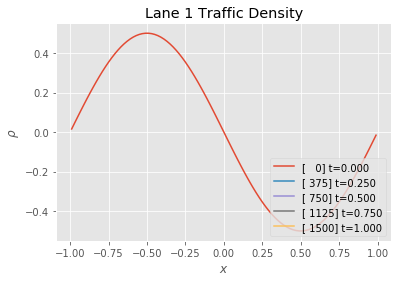

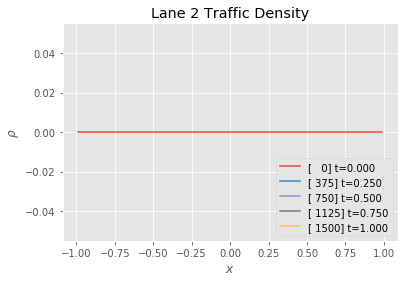

In [2]:
def source_zero(x, U):
    return 0*U

def fvsolve2systembc(riemann, U0, bc, source=source_zero,
                     a=-1, b=1, n=20, tfinal=2, t_step=None, limit=limit_minmod, args = ()):
    h = (b - a)/n
    if t_step is None:
        t_step = h/30
    
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    Ubcshape = (Ushape[0], Ushape[1]+4)
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n

#     def rhs(t, U):
#         U = U.reshape(Ushape)
#         jump = U[:,idxR] - U[:,idxL]
#         r = numpy.zeros_like(jump)
#         numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
#         g = limit(r) * jump / (2*h)
#         fluxL = riemann(U[:,idxL] + g[:,idxL] * h/2, U - g * h/2, *args)
#         return ((fluxL - fluxL[:,idxR]) / h
#                 + source(x, U)).flatten()
    
    def rhs(t, U):
        Ubc = numpy.empty(Ubcshape)
        Ubc[:,2:-2] = U.reshape(Ushape)
        bc(Ubc)
        jump = Ubc[:,2:] - Ubc[:,:-2]
        r = numpy.zeros_like(jump)
        numpy.divide(Ubc[:,1:-1] - Ubc[:,:-2], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        flux = riemann(Ubc[:,1:-2] + g[:,:-1] * h/2,
                       Ubc[:,2:-1] - g[:,1:] * h/2, *args)
        return ((flux[:,:-1] - flux[:,1:]) / h
                + source(x, Ubc[:,2:-2])).flatten()
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=t_step, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

class TwoLanesTraffic:
    def __init__(self, a=0.1):
        """
        Initializes the system of equations for two lanes of traffic, with the
        rate of vehicles switcing between lanes controlled by a.
        """
        self.a = a

    def density_1(self, U):
        """
        Returns the traffic density in lane 1 from U.
        """
        return U[0]

    def density_2(self, U):
        """
        Returns the traffic density in lane 2 from U.
        """
        return U[1]
    
    def flux(self, U):
        """
        Returns the flux for the two-lane traffic equations, evaluated at U:
        f(U) = [ p1 (1 - p1) ]
               [ p2 (1 - p2) ]

        Parameters:
          U: a 2xn matrix with the following rows
            0: p1, lane 1 traffic density
            1: p2, lane 2 traffic density

        Returns:
          the flux, f(U)
        """
        flux1 = U[0] * (1 - U[0])
        flux2 = U[1] * (1 - U[1])
        
        #TEST
#         if numpy.isnan(flux1).any():
#             print("flux 1")
#         if numpy.isnan(flux2).any():
#             print("flux 2")
            
        return numpy.array([flux1, flux2])

    def riemann_hll(self, UL, UR):
        p1L = UL[0]
        p1R = UR[0]
        
        p2L = UL[1]
        p2R = UR[1]
        
        sL = numpy.minimum(1 - 2 * p1L, 1 - 2 * p1R)
        sR = numpy.maximum(1 - 2 * p2L, 1 - 2 * p2R)

        fL = self.flux(UL)
        fR = self.flux(UR)
        
        return numpy.where(sL < 0, fL,
                numpy.where(sR < 0, fR,
                    (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))
    
    def bc_periodic(self, Ubc):
        Ubc[:,:2] = Ubc[:,-4:-2]
        Ubc[:,-2:] = Ubc[:,2:4]

    def source_lane_changes(self, x, U):
        """
        Evaluates the source term for two-lane traffic, representing vehicles 
        moving between the lanes.
        source = [ a (p2 - p1) ]
                 [ a (p1 - p2) ]
        """
        source = 0 * U
        source[0] = self.a * (U[1] - U[0])
        source[1] = - source[0]
        
        #TEST
#         if numpy.isnan(source[0]).any():
#             print("source[0]")
#         if numpy.isnan(source[1]).any():
#             print("source[1]")
            
        return source

    def initial_sin(self, x):
        p1 = numpy.sin(-numpy.pi * x)
        p2 = 0.5 * numpy.sin(-numpy.pi * x)
        return numpy.array([p1, p2])
    
    def initial_sin_2(self, x):
        p1 = 0.5 * numpy.sin(-numpy.pi * x)
        p2 = 0 * x
        return numpy.array([p1, p2])

def plot_densities(problem, x, hist, until=None, n=5):
    """
    Plots the density of traffic in two travel lanes in separate plots.
    """
    if until is None:
        laststep = len(hist) - 1
    else:
        laststep = numpy.searchsorted([t for t,U in hist], until)

    densities = [("Lane 1 Traffic Density", problem.density_1),
                 ("Lane 2 Traffic Density", problem.density_2)]

    for (name, get_density) in densities:
        pyplot.figure()
        for step in numpy.linspace(0, laststep, n, dtype=int):
            t, U = hist[step]
            pyplot.plot(x, get_density(U), 
                        label='[{: 4d}] t={:.3f}'.format(step, t))
        pyplot.xlabel("$x$")
        pyplot.ylabel("$\\rho$")
        pyplot.title(name)
        pyplot.legend(loc='lower right');

problem = TwoLanesTraffic(a=0.05)
x, hist = fvsolve2systembc(
                problem.riemann_hll, problem.initial_sin_2, problem.bc_periodic,
                source=problem.source_lane_changes, n=100, limit=limit_minmod, 
                args=())

plot_densities(problem, x, hist, until=1)

## Sources

Laval, Jorge A., Carlos F. Daganzo. "Lane-changing in traffic streams." _Transportation Research Part B: Methodological_ 40.3 (2006): 251-264. <br />
http://www.sciencedirect.com/science/article/pii/S019126150500055X

LeVeque, Randall J. _Numerical Methods for Conservation Laws_ Chapter 4. Basel, 1992. <br />
https://pdfs.semanticscholar.org/1470/c6f43c769572c4cfc94ffc9c5710484ff1e5.pdf

Holmes, Mark H. _Introduction to the Foundations of Applied Mathematics_. Vol. 56. Chapter 5. Springer Science & Business Media, 2009. <br />
http://pub.math.leidenuniv.nl/~chirilusbrucknerm/ds_seminar_2016/holmes_Ch5_traffic_flow.pdf

Munjal, P. K., Louis Albert Pipes. "Propagation of on-ramp density perturbations on unidirectional two-and three-lane freeways." _Transportation Research_ 5.4 (1971): 241-255. <br />
https://www.sciencedirect.com/science/article/pii/0041164771900360

Newell, Gordon F. "A simplified theory of kinematic waves in highway traffic, part I: General theory." Transportation Research Part B: Methodological 27.4 (1993): 281-287.<br />
http://www.sciencedirect.com/science/article/pii/019126159390038C

<!-- 
Papers behind Munjal and Pipes's paper.

Oliver, Robert M., and Tenny Lam. "Statistical experiments with a two-lane flow model." No. ORC-65-20. California Univeristy Berkeley Operations Research Center, 1965.<br />
http://www.dtic.mil/dtic/tr/fulltext/u2/622500.pdf

Gazis, Denos C., Robert Herman, and George H. Weiss. "Density oscillations between lanes of a multilane highway." _Operations Research_ 10.5 (1962): 658-667. <br />
http://www.jstor.org/stable/167887
-->